### Flight Purchase Recommendation Model:

In this pricing recommendation model, every flight is supposed to have its own distribution of prices as it relates to time. A flight will be "scored" with prices from the pricing model to simulate the pricing curve until two weeks before departure. If the current price falls in the bottom 20% of pricing curve by rank order then a recommendation is generated to "buy" the flight; otherwise the recommendation is generated to "wait" to purchase. 
<br>
<br>
I began with an EDA of a single trip's historical pricing data to familarize myself with the distributions of the flight prices and potential features. For a first pass regression model, I chose a Random Forest regression algorithm to predict flight prices as a first pass due to its nature of avoiding overfitting with minimal hyperparameter tuning. Next, I reviewed each sample data column to generate about 40 potential features. I excluded quite a few datetime features to ensure that time trend feature "advance" would be adequately captured as a predictor. Otherwise, changing the advance feature for price simulations might undercapture the actual sensitivity to changes in the time up until flight departure. My holdout lift curve and RMSE metric suggest that the model predicts surprisingly well with little tuning, but care should be taken to ensure absolutely no data leakage has occurred. Running the last cell will select a random flight, generate a pricing curve, and provide a purchase recommendation. 
<br>
<br>
If I continued this project, I'd spend more time running more traditional time series analysis, such as ACF and PACF plots. I'd also build an ARIMA model and test the accuracy using a more novel method, such as Facebook's Prophet tool or a variational time series LSTM. An ARIMA might fit the pricing data worse than a random forest, but parametric models such as ARIMA are often more robust to simulating changes such as the "advance" time trend in this model.

### Columns:

- search_id: the bundle identifer 
- trip_index: the index of the trip within a bundle
- received_date: date the trip was received
- received_ms: epoch milliseconds trip was received
- origin: origin airport
- destination: destination airport
- total_usd: total fare including taxes and fees
- pax_type: passenger type quoted
- refundable: refundable fare indicator
- validating_carrier: airline selling the ticket
- departure_odate: departure date in origin TZ
- departure_ms: epoch milliseconds of departure
- outgoing_duration: total in minutes 
- outgoing_stops: number of stops on outbound trip
- return_odate: return date in destination TZ
- return_ms: epoch millis of return time
- returning_duration: total in minutes
- returning_stops: number of stops on return trip
- major_carrier_id: airline delivering majority of flight time
- total_stops: total stops for round-trip
- advance: days search before departure
- length_of_stay: nights between departure and return
- includes_saturday_night_stay: indicator for saturday stayover (pred)
- available_seats: quoted availability at search time (pred?)
- lowest_cabin_class: lowest cabin class over all flights (pred)
- highest_cabin_class: highest cabin class over all flights (pred)



## I. Import Libraries and Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import date
from datetime import datetime
import timeit

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.feature_selection import RFE
from sklearn.base import TransformerMixin
from sklearn.utils import resample
from sklearn.externals import joblib

In [4]:
flights = pd.read_csv(r'price/longitudinal_trim.csv')


In [5]:
flights_sample = flights.iloc[0:1000]
flights_sample.to_csv(r'price/sample.csv')

## II. EDA

In [6]:
# search_id.columns
flights_sample.head()

,Unnamed: 0,search_id,trip_index,received_date,received_ms,origin,destination,total_usd,pax_type,refundable,...,returning_duration,returning_stops,major_carrier_id,total_stops,advance,length_of_stay,includes_saturday_night_stay,available_seats,lowest_cabin_class,highest_cabin_class
0,2451655,660209ae-7069-3a59-b193-61f2ee51016e,135,2016-03-02,1456966043892,BOS,CUN,488.69,ADT,NaN,...,432,1,UA,2,57,4,True,9,E,E
1,359790,8f562a7c-fa2b-3107-99e2-5860f6b0264b,43,2016-10-22,1477189113113,BOS,CUN,740.93,ADT,NaN,...,1275,1,UA,2,31,5,True,4,E,E
2,1888451,708067b6-3ae1-30a0-ac5f-370bb69eb937,192,2016-04-25,1461587327634,BOS,CUN,497.80,ADT,NaN,...,441,1,AA,2,15,7,True,9,E,E
3,2973055,33531f8d-e4b4-3dbc-a0ea-a480834ee1ae,159,2016-12-03,1480794140210,BOS,CUN,383.58,ADT,NaN,...,248,0,B6,1,189,7,True,9,E,E
4,1783576,72aec7bf-c516-3282-8802-28e22a0042be,41,2016-10-03,1475535295102,BOS,CUN,315.93,ADT,NaN,...,452,1,AA,2,41,4,False,9,E,E


In [7]:
flights['refundable'].value_counts()

Series([], Name: refundable, dtype: int64)

In [8]:
len(set(flights.search_id))
# avg 3 count per unique search IDs
#
search_id = flights.groupby(['search_id'])['search_id'].count()

print(search_id.shape)
search_id.head(20)

(106737,)


search_id
00017fed-4c3b-3721-9d52-d3def47b94d2    4
00027d0e-c5bf-3a7c-b515-34b1290d61c7    3
00028d9a-e0eb-3a5f-b2ee-136972976547    1
0003d6d6-2200-3120-b5f1-4149ab8ac710    1
00042e4d-7b62-3402-b613-2d7b7c7b4ea4    7
00048743-8fa3-3f28-921f-8f0aa85a2bb6    4
00049ffd-69ef-3e5e-ba6d-375bf887e869    1
0004ae06-6982-3eef-885a-e2cd2191ba71    1
00051e35-2c0e-3cf2-b31f-686411ee5282    2
00057273-512b-3285-b07b-c3bccabf79cd    7
00057740-5226-33d1-aa84-ac9f33683373    1
0005b838-000d-38d7-a768-8e7a3bc28f28    1
0005bace-949a-30e3-a042-a22fbe9fa6f0    3
0005e31d-ce4e-33bc-ae8b-e17e166213c2    4
00069189-50d7-3a23-a92a-2dacdefeee73    4
00078bb5-c5bc-3d64-b594-5982d9f90e5c    2
00082080-3261-3722-a39b-8efac4acae53    4
000875de-42c3-3a30-b2c7-9e0e1bd2120a    4
000963fc-8fe8-343e-a666-9902eeaad4eb    1
0009f3be-da1d-3675-8c99-89425350a0ca    5
Name: search_id, dtype: int64

### Plot distribution of "search_id" counts:

Distribution of Search ID Counts:


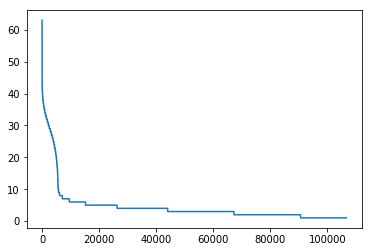

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1cf8b710>]],
      dtype=object)

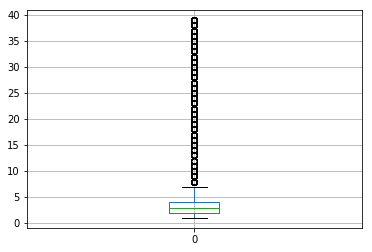

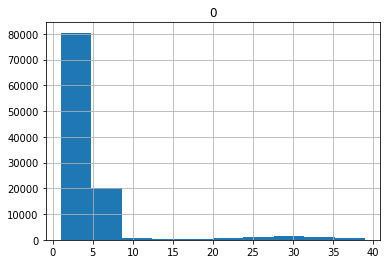

In [9]:
search_id_plot = -np.sort(-search_id)
plt.plot(search_id_plot)
print("Distribution of Search ID Counts:")
plt.show()

search_id_box = search_id_plot[np.where(search_id_plot < 40)]
pd.DataFrame(search_id_box).boxplot()
pd.DataFrame(search_id_box).hist()

### Plot Distribution of Flight Prices Under Differing Thresholds:

Distribution of Flight Prices Under $2000


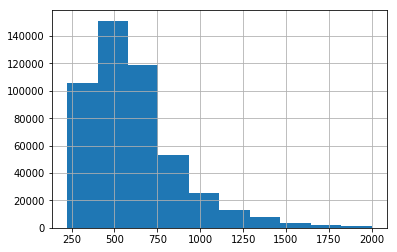

Distribution of Flight Prices Under $1000


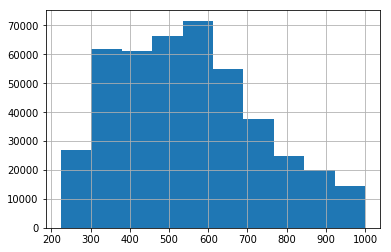

In [10]:
print("Distribution of Flight Prices Under $2000")
flights[flights['total_usd'] < 2000]['total_usd'].hist()
plt.show()
print("Distribution of Flight Prices Under $1000")
flights[flights['total_usd'] < 1000]['total_usd'].hist()
plt.show()

In [11]:
flight_cats = flights.loc[:,
                        ['pax_type','refundable'
                          ,'origin','destination','validating_carrier'
                      ,'major_carrier_id','returning_stops','advance','length_of_stay'
                      ,'includes_saturday_night_stay','available_seats','lowest_cabin_class'	
                      ,'highest_cabin_class']]
for i in flight_cats.columns:
    print(flight_cats[i].value_counts(dropna=False))

ADT    424754
NaN     56751
Name: pax_type, dtype: int64
NaN    481505
Name: refundable, dtype: int64
BOS    481505
Name: origin, dtype: int64
CUN    481505
Name: destination, dtype: int64
UA     188265
AA     161010
NaN     56751
DL      39109
AM      12556
B6      11165
AC       9844
NK       1814
WS        717
SY        175
CM         85
VX          7
HR          4
AV          2
AS          1
Name: validating_carrier, dtype: int64
UA    209851
AA    161014
DL     67257
AM     13944
B6     13909
AC     11442
NK      2085
WS      1652
SY       182
CM       155
VX        11
AS         3
Name: major_carrier_id, dtype: int64
1    420502
2     46636
0     14133
3       234
Name: returning_stops, dtype: int64
4      5607
3      5408
2      5080
6      4857
1      4852
5      4640
14     4619
7      4470
31     4297
15     4174
24     4145
44     3944
30     3900
10     3770
16     3734
23     3729
22     3720
8      3719
11     3708
25     3691
21     3657
20     3627
12     3626
28     36

In [12]:
flights.columns

Index(['Unnamed: 0', 'search_id', 'trip_index', 'received_date', 'received_ms',
       'origin', 'destination', 'total_usd', 'pax_type', 'refundable',
       'validating_carrier', 'departure_odate', 'departure_ms',
       'outgoing_duration', 'outgoing_stops', 'return_odate', 'return_ms',
       'returning_duration', 'returning_stops', 'major_carrier_id',
       'total_stops', 'advance', 'length_of_stay',
       'includes_saturday_night_stay', 'available_seats', 'lowest_cabin_class',
       'highest_cabin_class'],
      dtype='object')

/Users/Tanner/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


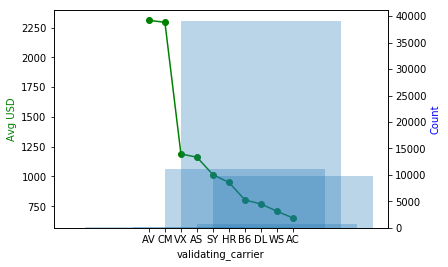

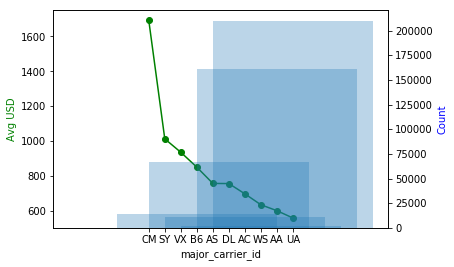

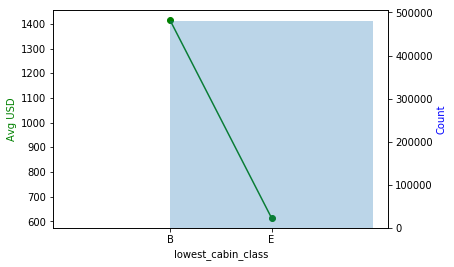

In [13]:
# Univariate 
uni_cols = ['validating_carrier'
#             ,'advance'
#             ,'includes_saturday_night_stay'
#             ,'length_of_stay'
            ,'major_carrier_id'
            ,'lowest_cabin_class'
#             ,'total_stops'
           ]


for col in uni_cols:
    flights_group1 = flights.groupby(col,sort=False)[col,'total_usd'].agg({
        'count': 'count',
        'mean': 'mean'})
    flights_group1.columns = [col,'count','total_usd_mean']
    flights_group2 = flights_group1.sort_values('total_usd_mean',ascending=False)

    x_bar = flights_group2[col].index[0:10]
    y_bar = flights_group2['count'][0:10]
    y_line = flights_group2['total_usd_mean'][0:10]

    y_line = flights_group2['total_usd_mean'][0:10]

    y1 = flights_group2[col].index[0:10]
    y2 = flights_group2['count'][0:10]

    fig, ax1 = plt.subplots()
    ind = [x for x, _ in enumerate(x_bar)]

    ax2 = ax1.twinx()
    ax2.bar(y1, y2, 'b-',alpha=0.3)
    ax1.plot(y1, y_line, 'g-',marker='o')

    ax1.set_xlabel(col)
    ax1.set_ylabel('Avg USD', color='g')
    ax2.set_ylabel('Count', color='b')

    plt.show()

## III. Create Time Features and Prepare Other Variables


Using 700k flights as a representative sample

In [14]:
flights_test = flights.sample(300000)

flights_test['pax_type_full'] = flights['pax_type'].fillna('missing')
flights_test['pax_type_full'].value_counts()

ADT        264696
missing     35304
Name: pax_type_full, dtype: int64

In [15]:
#Past price features - if we have time, create a timeline of all prices for every historical day for each airline

historical_prices = flights.groupby(
    ['received_date','departure_odate'
     ,'return_odate','major_carrier_id','departure_ms','return_ms'
    ]
)['total_usd'].agg({'max':'max'
                  ,'min':'min'
                  ,'mean':'mean'})

len(historical_prices)
# price_ratio_1_days = 
# price_ratio_7_days = 
# price_ratio_30_days = 
# price_ratio_90_days = 
# price_ratio_180_days = 

/Users/Tanner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


434248

In [16]:
historical_prices.sample(10)

,,,,,,max,min,mean
received_date,departure_odate,return_odate,major_carrier_id,departure_ms,return_ms,,,
2016-02-23,2016-02-27,2016-03-05,DL,1456569000000,1457179200000,654.39,654.39,654.39
2016-10-25,2016-12-09,2016-12-17,AA,1481277600000,1482005700000,317.43,317.43,317.43
2016-03-01,2016-10-07,2016-10-11,UA,1475850600000,1476206100000,848.19,848.19,848.19
2016-07-26,2016-08-22,2016-08-26,UA,1471864500000,1472241480000,681.47,681.47,681.47
2016-03-30,2016-04-15,2016-04-19,AA,1460712600000,1461084900000,714.69,714.69,714.69
2015-09-19,2016-01-05,2016-01-12,DL,1452000600000,1452603600000,437.83,437.83,437.83
2016-05-15,2016-06-29,2016-07-03,UA,1467198000000,1467545400000,497.08,497.08,497.08
2015-08-22,2015-11-19,2015-11-23,DL,1447929600000,1448280000000,1222.28,1222.28,1222.28
2016-09-30,2016-11-08,2016-11-14,UA,1478614920000,1479141600000,377.69,377.69,377.69


In [17]:
print(flights['received_date'].head())
print(flights['departure_odate'].head())
print(flights['return_odate'].head())

date_columns = ['received_date','departure_odate','return_odate']


flights_test['received_date_dt'] = flights_test['received_date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
flights_test['departure_date_dt'] = flights_test['departure_odate'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
flights_test['return_date_dt'] = flights_test['return_odate'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

0    2016-03-02
1    2016-10-22
2    2016-04-25
3    2016-12-03
4    2016-10-03
Name: received_date, dtype: object
0    2016-04-28
1    2016-11-22
2    2016-05-10
3    2017-06-10
4    2016-11-13
Name: departure_odate, dtype: object
0    2016-05-02
1    2016-11-27
2    2016-05-17
3    2017-06-17
4    2016-11-17
Name: return_odate, dtype: object


In [18]:
flights_test['days_until_return'] = (flights_test['return_date_dt'] - flights_test['received_date_dt'])
flights_test['days_until_return'].head()

test = flights_test['days_until_return']/ np.timedelta64(1, 'D')
test[0:10]

362590     50.0
25821      37.0
52060     137.0
247172     98.0
274126    167.0
415587    108.0
293691     85.0
51464      82.0
200564      9.0
39127      22.0
Name: days_until_return, dtype: float64

### Prepare date variables:

In [19]:
# If we had more time, using received_ms we could bring in hour, minute as cyclical continuous features 
# using sin function, or create a "time of day" bucket (e.g., morning, evening, etc.)

# days until departure should already be defined with "advance", but doing manual check
flights_test['days_until_departure'] = (flights_test['departure_date_dt'] - flights_test['received_date_dt'])
flights_test['days_until_departure'] = flights_test['days_until_return']/ np.timedelta64(1, 'D')

# flights_test['days_until_departure'] = flights_test['days_until_departure'].astype('int')
flights_test['days_until_return'] = (flights_test['return_date_dt'] - flights_test['received_date_dt'])
flights_test['days_until_return'] = flights_test['days_until_return']/ np.timedelta64(1, 'D')
# flights_test['days_until_return'] = flights_test['days_until_return'].astype('int')

def weekend(x):
    if x >= 5:
        return 1
    else:      
        return 0

flights_test['received_date_year'] = flights_test['received_date_dt'].dt.year
flights_test['received_date_quarter'] = flights_test['received_date_dt'].dt.quarter
flights_test['received_date_month'] = flights_test['received_date_dt'].dt.month
flights_test['received_date_week'] = flights_test['received_date_dt'].dt.week
flights_test['received_date_day'] = flights_test['received_date_dt'].dt.day
flights_test['received_date_day_of_week'] = flights_test['received_date_dt'].dt.dayofweek
flights_test['received_date_week_of_year'] = flights_test['received_date_dt'].dt.weekofyear
flights_test['received_date_weekend_flag'] = flights_test['received_date_day_of_week'].apply(weekend) 

flights_test['departure_date_year'] = flights_test['departure_date_dt'].dt.year
flights_test['departure_date_quarter'] = flights_test['departure_date_dt'].dt.quarter
flights_test['departure_date_month'] = flights_test['departure_date_dt'].dt.month
flights_test['departure_date_week'] = flights_test['departure_date_dt'].dt.week
flights_test['departure_date_day'] = flights_test['departure_date_dt'].dt.day
flights_test['departure_date_day_of_week'] = flights_test['departure_date_dt'].dt.dayofweek
flights_test['departure_date_week_of_year'] = flights_test['departure_date_dt'].dt.weekofyear
flights_test['departure_date_weekend_flag'] = flights_test['departure_date_day_of_week'].apply(weekend)

flights_test['return_date_year'] = flights_test['return_date_dt'].dt.year
flights_test['return_date_quarter'] = flights_test['return_date_dt'].dt.quarter
flights_test['return_date_month'] = flights_test['return_date_dt'].dt.month
flights_test['return_date_week'] = flights_test['return_date_dt'].dt.week
flights_test['return_date_day'] = flights_test['return_date_dt'].dt.day
flights_test['return_date_day_of_week'] = flights_test['return_date_dt'].dt.dayofweek
flights_test['return_date_week_of_year'] = flights_test['return_date_dt'].dt.weekofyear
flights_test['return_date_weekend_flag'] = flights_test['return_date_day_of_week'].apply(weekend)

# flights_test['return_date_day_of_week'].value_counts()
# flights_test['return_date_day'].value_counts()

# flights_test['days_until_return'].value_counts()
# flights_test['days_until_departure'].value_counts()

## IV. Begin RF Model

### Define Features:

In [20]:
features = [    
    # target (will drop)
    'total_usd'
    
    #time variable
    ,'advance'
    
        # key time series variables - commenting out so advance gets precedence and we don't overlap 
#     ,'days_until_departure','days_until_return'
    ,'pax_type_full'
    ,'validating_carrier','major_carrier_id'
    ,'outgoing_stops','returning_stops'
    ,'length_of_stay','available_seats'
    ,'lowest_cabin_class','highest_cabin_class'
    ,'outgoing_duration','returning_duration'
#     ,'received_ms','departure_ms','return_ms'
   
    ,'includes_saturday_night_stay'

    
#       # key date variables - removed many without sacrificing too much accuracy
    ,'received_date_day_of_week','received_date_weekend_flag','received_date_month'
#     ,'received_date_year','received_date_quarter','received_date_week'
#     ,'received_date_day','received_date_week_of_year'
   
    ,'departure_date_day_of_week','departure_date_weekend_flag','departure_date_month'
#     ,'departure_date_year','departure_date_quarter','departure_date_week'
#     ,'departure_date_day','departure_date_week_of_year'
   
    ,'return_date_day_of_week','return_date_weekend_flag','return_date_month'
#     ,'return_date_year','return_date_quarter','return_date_week'
#     ,'return_date_day','return_date_week_of_year'
          
    # past price ratios (if time)
]



### Impute Features with Mean or Most Frequent Values for Simplicity:

In [21]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values--
         dtype objects imputed with the most frequent value 
         other types are imputed with mean 
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

data = [
    ['a', 1, 2],
    ['b', 1, 1],
    ['b', 2, 2],
    [np.nan, np.nan, np.nan]
]

### Run imputation and transform features into dummy space:

In [23]:
# flights_test = flights_test.reset_index()

flights_test_features = flights_test[features]

random.seed(9999)
flights_test_features['random'] = [random.random() for i in range(len(flights_test_features))]

flights_test_features_impute = DataFrameImputer().fit_transform(flights_test_features)

flight_train = flights_test_features_impute.loc[flights_test_features_impute['random'] < .75,:]
flight_test = flights_test_features_impute.loc[flights_test_features_impute['random'] >= .75,:]
print(flight_train.shape)
print(flight_test.shape)

# flight_train_impute = DataFrameImputer().fit_transform(flight_train)
# flight_test_impute = DataFrameImputer().fit_transform(flight_test)

train_features = pd.get_dummies(flight_train)

test_features = pd.get_dummies(flight_test)
train_features = train_features[test_features.columns]

train_target = train_features['total_usd']

test_target = test_features['total_usd']

train_features = train_features.drop(['total_usd','random'],axis=1)

test_features = test_features.drop(['total_usd','random'],axis=1)

print(train_features.shape)
print(test_features.shape)


/Users/Tanner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(225000, 24)
(75000, 24)
(225000, 47)
(75000, 47)


### Run random forest model:

In [24]:
start = timeit.default_timer()
model = sklearn.ensemble.RandomForestRegressor(bootstrap=True, 
#                                                criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0
            , n_estimators=1000
            , n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

model.fit(train_features,train_target)


end = timeit.default_timer()
print("Total time:",round(end - start,4), "seconds")

Total time: 1753.7364 seconds


In [25]:
# Save RF model, which took about an hour to run (3.28 GB)
filename = 'finalized_model.sav'
# joblib.dump(model, filename)

### Predict train and holdout prices and visualize most important predictors:

126.08904814246041
                            Importance
highest_cabin_class_E           0.1291
return_date_month               0.1251
departure_date_month            0.0968
advance                         0.0962
returning_duration              0.0951
return_date_day_of_week         0.0912
received_date_month             0.0550
outgoing_duration               0.0508
length_of_stay                  0.0441
departure_date_day_of_week      0.0436
pax_type_full_missing           0.0251
validating_carrier_DL           0.0245
major_carrier_id_B6             0.0178
available_seats                 0.0154
major_carrier_id_UA             0.0126
return_date_weekend_flag        0.0097
received_date_day_of_week       0.0087
returning_stops                 0.0075
pax_type_full_ADT               0.0071
major_carrier_id_DL             0.0064


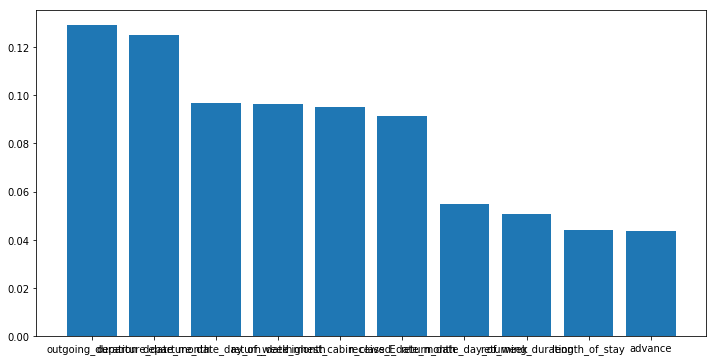

,test_predict,test_target
28994,708.669306,422.69
23255,573.305007,669.26
50042,844.000007,1076.91
33449,528.949657,462.52
4858,485.450183,428.80
46795,610.862538,547.69
41322,666.278442,573.39
10207,759.090002,782.52
15664,1291.834718,1329.02
19575,674.090910,752.79


In [26]:
test_predict = model.predict(test_features)
train_predict = model.predict(train_features)


def rmse(y_true,y_pred):
    return np.sqrt(sklearn.metrics.mean_squared_error(y_true,y_pred))

print(rmse(test_target,test_predict))

# plot_features(model,(10,14))
feature_importances = model.feature_importances_
importance_table = pd.DataFrame(feature_importances, index=train_features.columns, 
                          columns=["Importance"]).sort_values(by=['Importance'],ascending=False)
importance_table['Importance'] = round(importance_table['Importance'],4)
print(importance_table.head(20))

# ***visualize top 10 or more predictors
x_bar = set(importance_table.index[0:10])
y_bar = importance_table['Importance'][0:10]
ind = [x for x, _ in enumerate(x_bar)]
plt.rcParams['figure.figsize'] = [12, 6]

plt.bar(ind,y_bar)
plt.xticks(ind,x_bar)
plt.show()


compare = pd.DataFrame()
compare['test_predict'] = test_predict
compare['test_target'] = np.array(test_target)

# test_target
compare.sample(20)

### Generate Predicted Price Distribution and Lift Curves:
A lift curve visualizes risk: first, it sorts all predicted-actual pairs by predicted value; second, it groups these pairs into x (in this case 30) evenly counted buckets; finally, it calculates and plots the mean of each predicted and actual price for each bucket.


Distribution of Predicted Flight Costs:


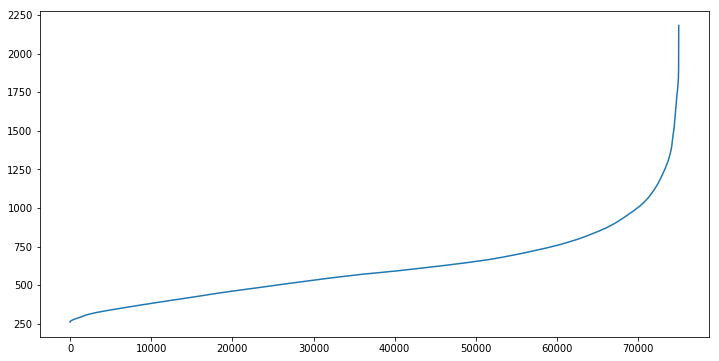

sum check: 46138814.5057 

sum check: 46089965.88 

total_usd
0      273.261304
1      298.294984
2      319.620664
3      340.180256
4      358.744516
5      377.756200
6      398.122052
7      419.843432
8      440.192244
9      459.736224
10     476.171624
11     494.063672
12     514.257784
13     536.891868
14     557.523048
15     572.732504
16     589.389940
17     605.223172
18     624.596972
19     643.793272
20     667.721492
21     694.322920
22     725.288708
23     759.611636
24     804.493788
25     859.391972
26     925.033208
27    1013.445856
28    1161.418180
29    1524.862860
Name: total_usd, dtype: float64 0      292.094146
1      327.490479
2      350.473775
3      371.546808
4      392.000904
5      411.816569
6      431.913293
7      452.038167
8      470.290341
9      487.845790
10     506.188154
11     523.684356
12     540.901563
13     557.382965
14     572.052548
15     584.858626
16     598.496645
17     613.359678
18     628.753157
19     645.139160
20    

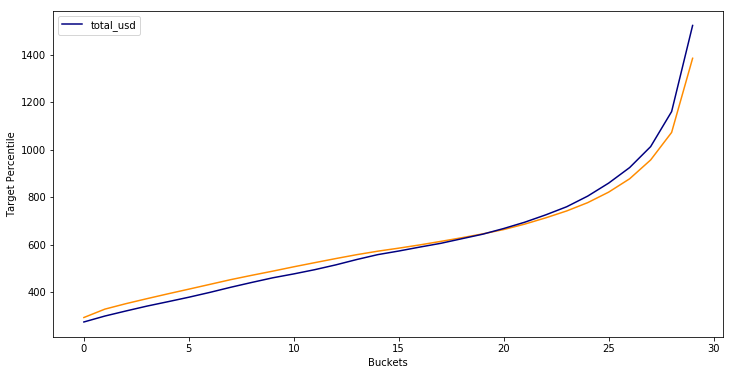

In [27]:
curve = np.sort(test_predict)
# curve = np.sort(test_target)
plt.plot(curve)
print("Distribution of Predicted Flight Costs:")
plt.show()

print("sum check:",round(test_predict.sum(),4),'\n')
print("sum check:",round(test_target.sum(),4),'\n')


def LiftCurve(actual, predicted, bins):
    actual_ranks = pd.qcut(actual.rank(method='first'),bins,labels=False)
    pred_ranks = pd.qcut(predicted.rank(method='first'),bins,labels=False)
    actual_percentiles = actual.groupby(actual_ranks).mean()
    pred_percentiles = predicted.groupby(pred_ranks).mean()
    
    
#     plt.title('Lift Chart')
    plt.plot(pred_percentiles,color='darkorange')
    plt.plot(actual_percentiles,color='navy')
    plt.ylabel('Target Percentile')
    plt.xlabel('Buckets')
    plt.legend(loc='best') 
    print(actual_percentiles,pred_percentiles)

    
LiftCurve(test_target,pd.Series(test_predict),30)
    

## V: Run Pricing Recommendation Algorithm on Randomly Generated Flight:
Buy flight if current price is in the top 20% of future predicted flight prices. 
Scoring for each day - pick test search_id and run for every day or every 3 days for up to 8 months

In [42]:
# begin creating single flight scoring simulation
test_features_simulate = test_features.copy()

# Generate random search_id and trip_index to use
    # random_flight = test_features_simulate.loc[:,['search_id','trip_index']].sample(1)
    # random_search_id = random_flight.iloc[0,0]
    # random_trip_index = random_flight.iloc[0,1]
    # print("Random Search ID:", random_search_id)
# print(random_trip_index)

# print(test_features_simulate.shape)
test_features_simulate['search_id'] = flights_test['search_id']
test_features_simulate['total_usd'] = flights_test['total_usd']
test_features_simulate['trip_index'] = flights_test['trip_index']
# print(test_features_simulate.shape)

random_flight = test_features_simulate.loc[:,['search_id','trip_index']].sample(1)
random_search_id = random_flight.iloc[0,0]
random_trip_index = random_flight.iloc[0,1]
print("Random Search ID:", random_search_id)

# search_id = '3ac1c217-92ea-3d99-b705-cbd3e6639006'
search_id = random_search_id
# trip_index = 57
trip_index = random_trip_index

test_features_simulate_single = test_features_simulate[(test_features_simulate['search_id'] == search_id)
                                                      & (test_features_simulate['trip_index'] == trip_index)
                                                      ]
original_price = test_features_simulate_single.loc[:,'total_usd'].iloc[0]                                                 
# print(test_features_simulate_single.head())
test_features_simulate_single_score = test_features_simulate_single.drop(['total_usd','search_id','trip_index'],axis=1)


original_advance = test_features_simulate_single.loc[:,'advance'].iloc[0]
test_features_simulate_single_score.loc[:,'advance'].iloc[0] = original_advance
print("Original Advance # of Days:",original_advance)

def score_flight():
    global predict_price
    global advance_value
    global low_threshold       
    predict_price = pd.Series()
        
    while test_features_simulate_single_score.loc[:,'advance'].iloc[0] > 14:
        predict_price = predict_price.append(pd.Series(model.predict(test_features_simulate_single_score)))
        test_features_simulate_single_score.loc[:,'advance'].iloc[0] = test_features_simulate_single_score.loc[:,'advance'].iloc[0] - 3
        advance_value = test_features_simulate_single_score.loc[:,'advance'].iloc[0]
    else: 
        if original_advance <= 14:
            print("Departure date is less than two weeks away: No recommendation!")
        else:
            low_threshold = round(np.percentile(predict_price,20),2)
            if low_threshold <= original_price:
                print("Original Flight Price:",original_price)
                print("Future Low 20% Threshold:",low_threshold)
                print('WAIT')
            else:
                print("Original Flight Price:",original_price)
                print("Low Future Threshold:",low_threshold)
                print('BUY')

score_flight()
# print(advance_value)
# print(predict_price)
# print(low_threshold)
# print("Original Flight Price:",original_price)
# print("Low Future Threshold:",low_threshold)


Random Search ID: af31ef7c-0632-3d74-8135-26a337aeccb4
Original Advance # of Days: 175
Original Flight Price: 507.69
Low Future Threshold: 518.46
BUY
